#### 시계열분석 정상성 확인 요약
- 평균일정 X -> 차분
- 분산 일정 X -> 로그변환(np.log)

1. 시계열 데이터 불러와서 데이터 가공
2. 정규성 이분산성 시각화 필요한지 확인 후 필요하면 수행
3. ACF, PACF 시각화 adf test로 비정상 시계열 확인
4. 차분 등 수행 후 3번과 비교하여 정상 시계열 변환 완료 확인

In [34]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')
import pandas as pd
import matplotlib.pyplot as plt

series = pd.read_csv('market-price.csv', header=0, names = ['day', 'price'])
series['day'] = pd.to_datetime(series['day'])

series.index = series['day']
series.set_index('day', inplace=True)
series.tail()

,price
day,
2022-09-19,19415.86
2022-09-20,19542.20
2022-09-21,18879.96
2022-09-22,18507.36
2022-09-23,19408.63


정상 시계열인지 아닌지 확인하기 위해 시각화 진행

In [35]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    
    plt.figure(figsize=(10,6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling std')
    plt.legend(loc='best')
    plt.show()

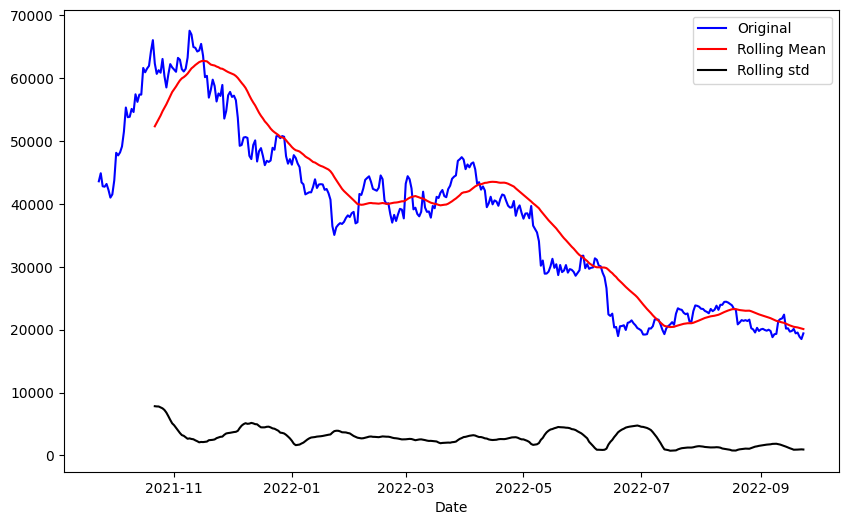

In [36]:
plot_rolling(series, 30)

평균은 꾸준히 하락하고 있다.

추세요인, 계절요인, 불규칙 요인 시각화

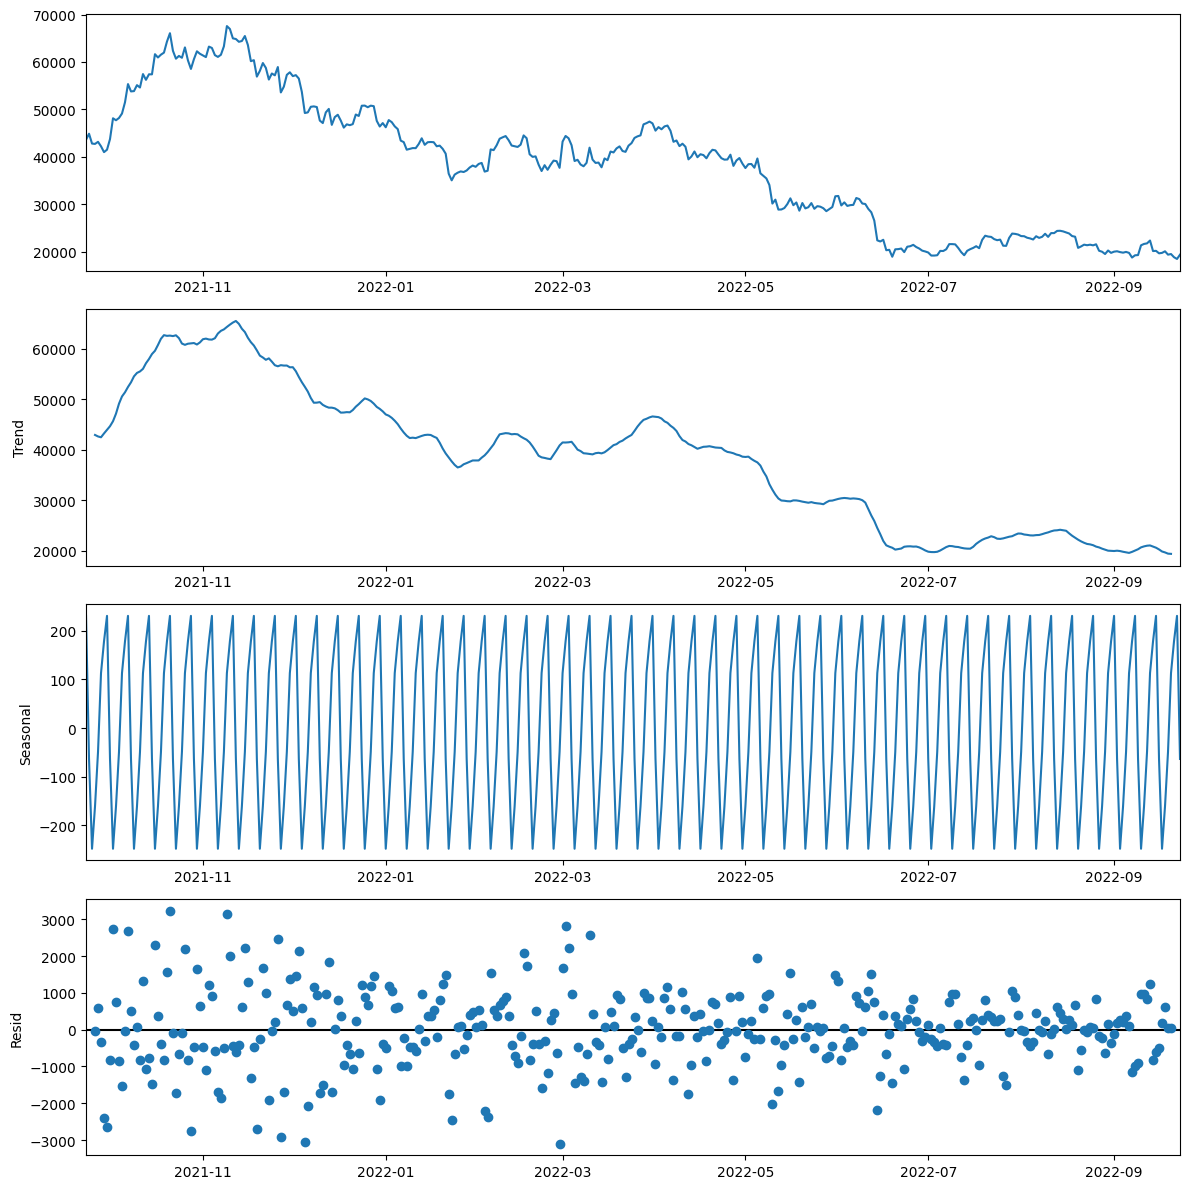

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = [12,12]
result = seasonal_decompose(series, model='additive')
result.plot()
plt.show()

- result.observed, result.trend, result.seasonal, result.resid로 그래프의 실제 값 확인
- result.observed - result.seasonal와 같은 방식으로 계절요인 제거 가능


#### 시계열 정상성 여부 분석
1. kpss test 
- 귀무가설 : 해당 시계열이 정상 시계열이다. 
2. ADP test
- 귀무가설 : 해당 시계열이 비정상 시계열이다. 

-> ADF 추천 

In [38]:
# kpss
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    
    print(f'KPSS Statistic : {statistic}')
    print(f'p-value " {p_value}')
    print(f'num lags : {n_lags}')
    print('Critical Values : ')
    
    for key, value in critical_values.items():
        print(f'{key} : {value}')
    print(f'Result : The series is {"not" if p_value<0.05 else ""} stationary')
    

kpss_test(series)

KPSS Statistic : 2.7387451421416498
p-value " 0.01
num lags : 11
Critical Values : 
10% : 0.347
5% : 0.463
2.5% : 0.574
1% : 0.739
Result : The series is not stationary


ACF 그래프
- 정상성을 나타내지 않는 데이터에서는 ACF가 느리게 감소
- 정상성을 나타내는 시계열에서는 ACF가 비교적 빠르게 0으로 감소

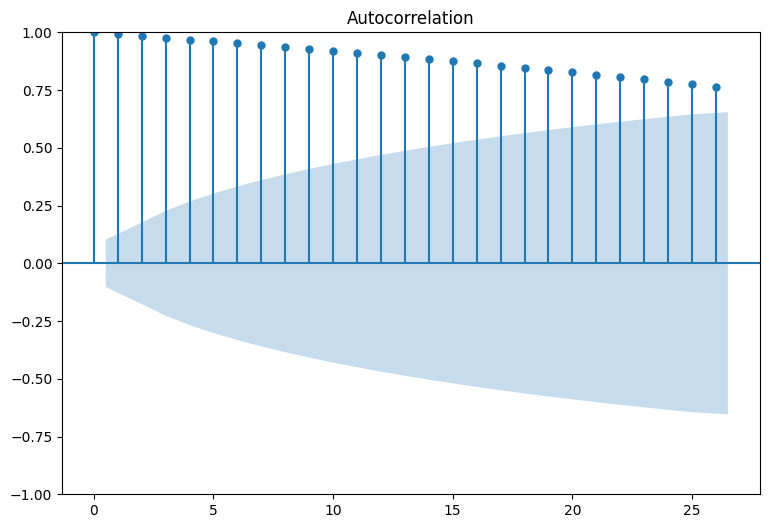

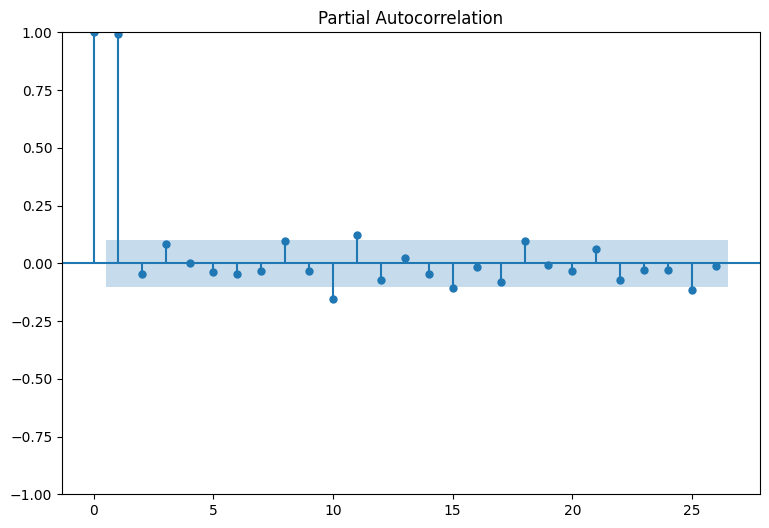

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams['figure.figsize'] = [9,6]
plot_acf(series)
plot_pacf(series)
plt.show()

ACF가 천천히 감소하기 때문에 비정상 시계열이라고 판단 

-> 차분을 통해 정상 시계열로 변환

KPSS Statistic : 0.15898983362547428
p-value " 0.1
num lags : 3
Critical Values : 
10% : 0.347
5% : 0.463
2.5% : 0.574
1% : 0.739
Result : The series is  stationary
None
---------------------------


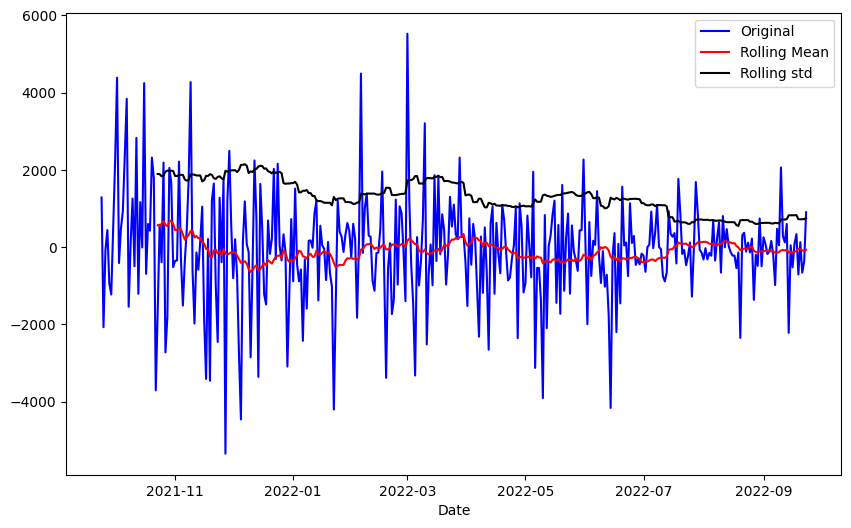

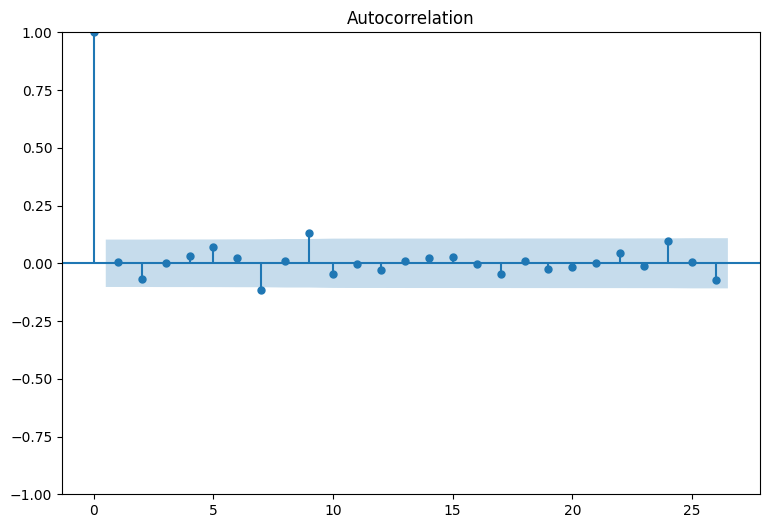

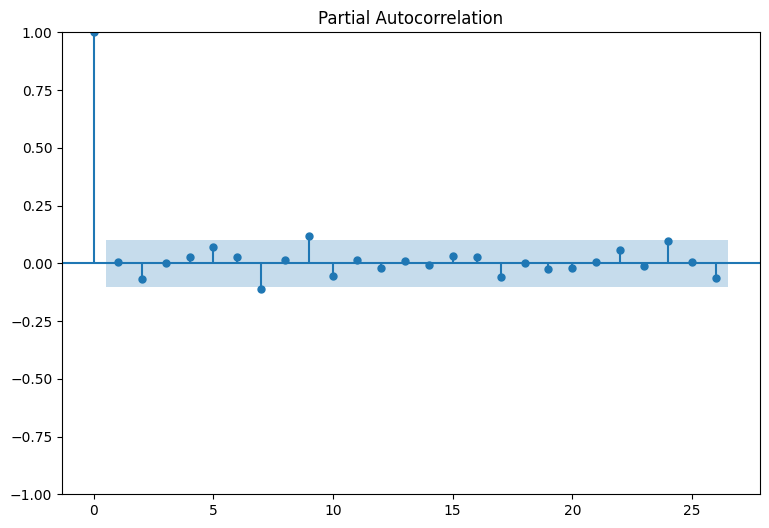

In [40]:
diff_1 = series.diff(periods=1).iloc[1:]
print(kpss_test(diff_1))
print('---------------------------')

plot_rolling(diff_1, 30)
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

1차 차분 진행 후 kpss test, 평균 분산 일정여부, ACF, PACF 시각화 결과이다.

ACF값이 확 감소하였고, 평균과 분산도 거의 일정함.

-> adf test 진행

귀무가설 : 비정상 시계열이다.

In [41]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(series)
print(f'원 데이터 ADF Statistic : {result[0]: .3f}')
print(f'원 데이터 p-value : {result[1]: .3f}')

result = adfuller(diff_1)
print(f'1차 차분 후 Statistic : {result[0]: .3f}')
print(f'1차 차분 p-value : {result[1]: .3f}')

원 데이터 ADF Statistic : -0.512
원 데이터 p-value :  0.890
1차 차분 후 Statistic : -18.934
1차 차분 p-value :  0.000


- 원 데이터 p-value가 0.89이므로 귀무가설을 채택(비정상)
- 1차 차분후 p-value가 0.001보다 작으므로 대립가설 채택(정상)

#### ARIMA 모델 생성
- trend : constant를 가지고 있는지 c:constant/nc : no constant
- disp : 수렴 정보를 나타냄

정상 시계열임을 확인하고 ARIMA로 예측 모형을 만듦

일단 (AR = 0, 차분=1, MA=1) 파라미터로 ARIMA 모델 학습

In [43]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(series['price'], order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  366
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3155.921
Date:                Sat, 24 Sep 2022   AIC                           6315.842
Time:                        06:02:37   BIC                           6323.641
Sample:                    09-23-2021   HQIC                          6318.941
                         - 09-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0325      0.048      0.676      0.499      -0.062       0.127
sigma2      1.903e+06   9.61e+04     19.797      0.000    1.71e+06    2.09e+06
Ljung-Box (L1) (Q):                   0.18   Jarque-

In [45]:
def my_auto_arima(data, order, sort="AIC"):
    order_list = []
    aic_list = []
    bic_list = []
    
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                    
                except:
                    pass
                
                result_df = pd.DataFrame(list(zip(order_list, aic_list)), columns =['order','AIC'])
                result_df.sort_values(sort, inplace=True)
    return result_df
my_auto_arima(series, [2,2,2])

,order,AIC
7,p1 d1 q1,6311.977617
2,p0 d1 q0,6314.563647
3,p0 d1 q1,6315.841629
6,p1 d1 q0,6315.939743
4,p1 d0 q0,6339.522584
5,p1 d0 q1,6341.473428
1,p0 d0 q1,7549.292223
0,p0 d0 q0,9799.733959


#### 잔차 분석
- 최적의 모델에서 나온 잔차를 그래프로 그려보고 acf, pacf 분석을 통해 잔차가 정상성을 가지는지 확인
- qqplot과 shapiro test, normaltest로 정규분포 형태를 가지는지 확인
- durbin_watson 검증을 통해 잔차의 자기상관관계여부 확인

In [49]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    
    plt.figure(figsize=(10,6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.show()

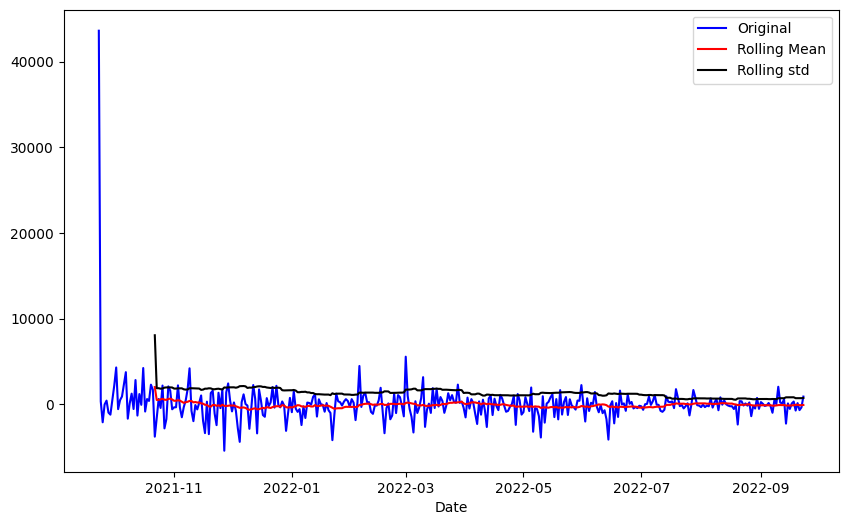

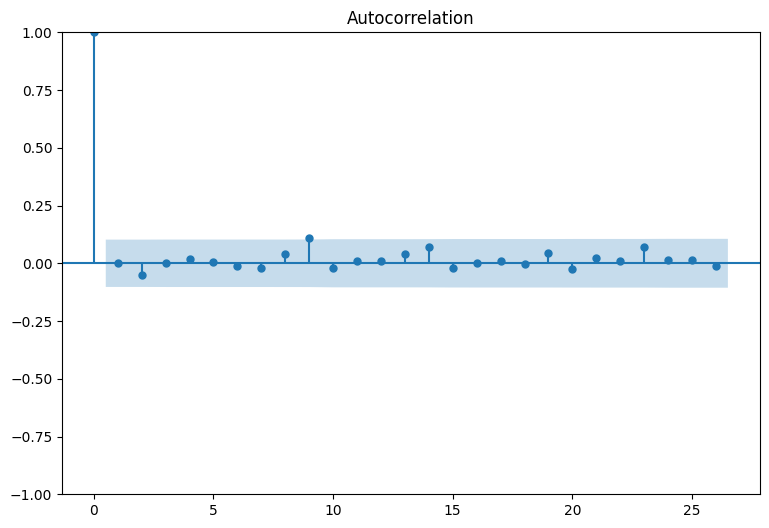

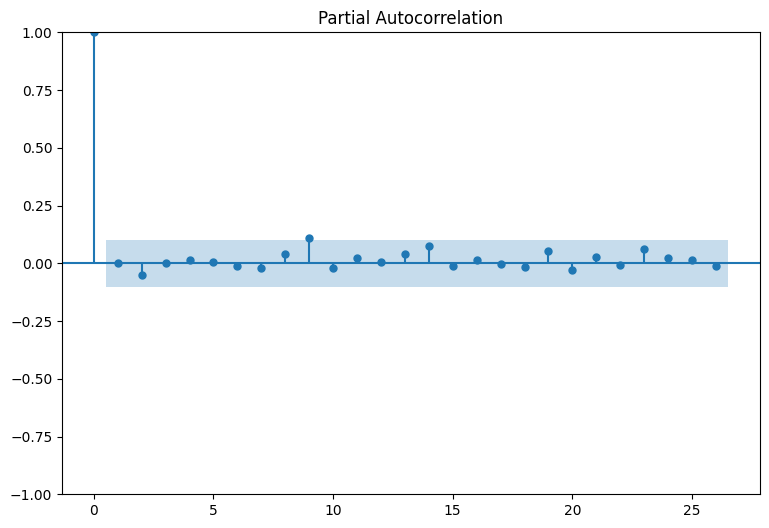

In [51]:
plt.rcParams['figure.figsize'] = [9,6]
plot_rolling(model_fit.resid, 30)
plot_acf(model_fit.resid)
plot_pacf(model_fit.resid)
plt.show()

잔차의 그래프를 확인해보면 1차 차분을 한 것과 모양이 굉장히 흡사하다.

평균을 일정해 보이는 것이 확인이 되었고 분산도 거의 일정하다고 할 수 있다. 

정상성을 추가로 확인하기 위해 ACF, PACF 표를 확인해본 결과 두 그래프에서 모두 절단점이 발견되지 않아 정상 시계열일 것으로 추측할 수 있다. 

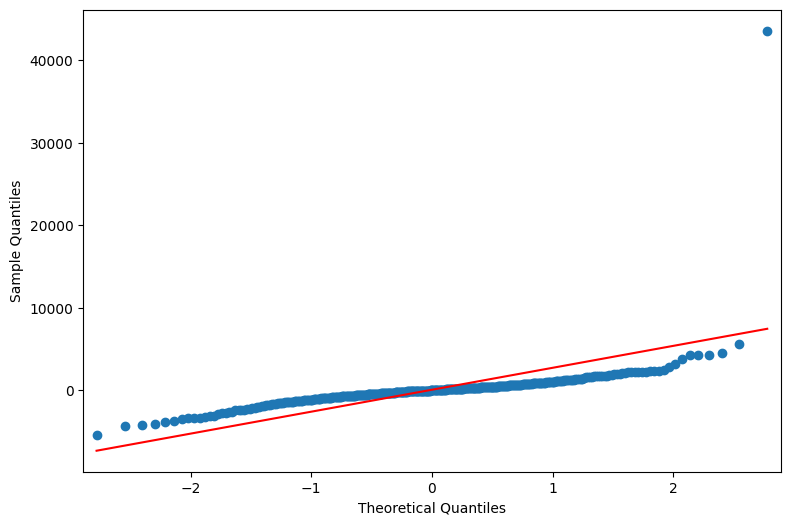

Statistic : %.3f, p : %.3f (0.40657055377960205, 6.87880927001971e-33)
Sample does not look Gaussian (reject H0)
-----------------------------------------
Statistics : 697.019, p:0.000
Sample does not look Gaussian (reject H0)


In [54]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, normaltest

qqplot(model_fit.resid, line='s')
plt.show()

stat1, p1 = shapiro(model_fit.resid)
print('Statistic : %.3f, p : %.3f', (stat1, p1))
alpha = 0.05

if p1 > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
print('-----------------------------------------')

stat2, p2 = normaltest(model_fit.resid)
print('Statistics : %.3f, p:%.3f' %(stat2, p2))

if p2 > alpha:
    print('Sample looks Gaussian (fail to resject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

durnin watson 검증

2에 가까울수록 auto correlation을 가지고 있지 않다는 가설 채택

In [55]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(model_fit.resid)

1.2648716106216784